# Example of using some simple tools for building a network model



First, let us load all the modules that will be needed.


In [1]:
%matplotlib inline

from network import Network

from scipy.sparse import csr_matrix
from allensdk.config.model.formats.hdf5_util import Hdf5Util

import numpy as np
import pandas as pd

import csv

import matplotlib.pyplot as plt

import random
random.seed(5) # Use the seed to initialize random number generator.
np.random.seed(150)

## Define objects and functions that will be used later

Here is a simple way of defining connection probabilities for different cell types.

In [2]:
# probabilities of establishing a connection from source -> target
connection_probabilities = { 
    ('nr5a1', 'nr5a1'): 0.5,
    ('nr5a1', 'pvalb'): 0.7,
    ('pvalb', 'nr5a1'): 0.8,
    ('pvalb', 'pvalb'): 0.9
}

Let us introduce a simple function for computing probability of connection between two cells based on the distance between their somata.

In [3]:
def distance_probability(p1, p2): # p1 and p2 are 3D vectors.
    ''' convert euclidean distance to probability of connection '''
    dist = np.linalg.norm(p1 - p2, 2) # Compute the distance.
    
    dist_cutoff = 200.0
    if (dist >= dist_cutoff):
        return 0.0
    else:
        return ( 1.0 - dist / dist_cutoff ) ** 2.0 # Use a simple formula for probability depending on the distance.

Why don't we check how that looks like?

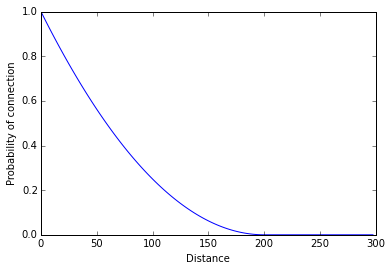

In [4]:
# Keep one point fixed and sample one dimension in the other to plot the probability as a function of distance.
p1 = np.array([0.0, 0.0, 0.0])
p2 = np.array([1.0, 0.0, 0.0])
r_array = np.arange(0.0, 300.0, 2.5) # Array of distances.
p_array = np.array([]) # Array of probabilities.
for r in r_array:
    p = distance_probability(p1, p2 * r) # Use p2 * r to obtain [r, 0, 0]; the distance between that and [0,0,0] is r.
    p_array = np.append(p_array, p)
plt.plot(r_array, p_array)
plt.xlabel('Distance')
plt.ylabel('Probability of connection')
plt.show()

Now, let us define a function for assigning connections based on the probability function of our choice.

In [5]:
def random_connectivity(src_i, tgt_i, source, target, cell_positions):
    ''' given a source target pair, create a connection (or not) '''

    # Do not allow self-connections.
    if (src_i != tgt_i):
        pdist = distance_probability(cell_positions[src_i], cell_positions[tgt_i])

        # Take the distance-dependent probability and scale it by a factor
        # that depends on the target and source types.
        p = pdist * connection_probabilities[source['type'],target['type']]

        # Draw a random number for this pair of cells and decide whether the connection should be established or not.
        if random.random() < p:
            # Establish the connection!
            # Assign a number of synapses that the source cell makes on the target cell.
            return { 'nsyns': random.randrange(2, 6) }


Now, define a function that converts the object we use to store information about connections to a convenient matrix.

In [6]:
def construct_matrix(connections):
    ''' turn a list of connection dictionaries into a numpy csr matrix '''
    cols = [ c['source'] for c in connections ]
    rows = [ c['target'] for c in connections ]
    data = [ c['nsyns'] for c in connections ]

    return csr_matrix((data, (rows, cols)))


## Populate the network

Generate a number of cells of different types; generate their positions.

In [7]:
N_nr5a1 = 8
N_pvalb = 2
N = N_pvalb + N_nr5a1

# cell positions
positions = 100.0 * np.random.random((N,3)) - 50.0 # x,y,z positions in a 100x100x100 box centered at (0,0,0).

# initialize the network
net = Network()

# add populations
net.add_population(N_nr5a1, type='nr5a1')
net.add_population(N_pvalb, type='pvalb')

## Connect cells in the network

All it takes is to provide the function that we described above!

In [8]:
# add the connectivity rule
net.connect(random_connectivity, cell_positions=positions) 

# build the matrix
cells, connections = net.build()

print 'Total number of connections: ', len(connections)

Total number of connections:  27


## Save data to files and print out some information about the network

Get the information about cells.

In [9]:
cells = pd.DataFrame.from_dict(cells)

cells['x'] = positions[:,0]
cells['y'] = positions[:,1]
cells['z'] = positions[:,2]

# Save the cells data to a csv file.
cells.to_csv('cells.csv', index=False)

print cells

   index   type          x          y          z
0      0  nr5a1  40.858394 -24.202836  37.765514
1      1  nr5a1  23.896548  19.807652   1.720855
2      2  nr5a1  45.210963  41.364452 -42.182553
3      3  nr5a1  28.232053 -38.633463  14.084992
4      4  nr5a1 -42.023698 -26.803396 -11.404849
5      5  nr5a1 -26.326493  49.838317 -11.065881
6      6  nr5a1  22.383694  -4.825395  -2.312675
7      7  nr5a1   4.526381  -6.720504   8.970608
8      8  pvalb -39.502891  36.110169 -19.196460
9      9  pvalb  -1.328607 -28.991945  12.008767


Now, use the function we prepared above to convert the information about connections to a nice matrix.
Save that matrix to a binary HDF5 file.

In [10]:
# turn it into a sparse matrix
if len(connections) > 0:
    m = construct_matrix(connections)
    print '(tgt, src)  nsyns'
    print m

    # write the connectivity to hdf5
    Hdf5Util().write('connections.h5', m)



(tgt, src)  nsyns
  (0, 6)	5
  (1, 4)	3
  (1, 5)	5
  (1, 7)	5
  (1, 8)	2
  (2, 1)	3
  (2, 5)	4
  (2, 7)	3
  (3, 2)	2
  (3, 4)	4
  (3, 9)	5
  (4, 5)	5
  (4, 8)	2
  (4, 9)	3
  (6, 1)	2
  (6, 2)	5
  (6, 9)	4
  (7, 0)	3
  (7, 1)	5
  (8, 5)	2
  (8, 6)	4
  (9, 1)	5
  (9, 3)	2
  (9, 4)	3
  (9, 5)	5
  (9, 7)	3
  (9, 8)	4
